# Red Zone Efficiency
Calculating NFL redzone efficiency based on percentage of possible points scored in redzone trips rather than the 2 typical calculations — percentage of redzone trips resulting in any points or a touchdown.

## Setup

In [1]:
# import nfl_data_py
try:
    import nfl_data_py as nfl
except:
    try:
        %pip install nfl_data_py
        import nfl_data_py as nfl
        print("Installed nfl_data_py")
    except:
        # most common error with installing nfl_data_py is because pandas is only supported <2.0
        %pip install pandas=1.5.3
        %pip install nfl_data_py
        import nfl_data_py as nfl
        print("Installed pandas v1.5.3 and nfl_data_py")
finally:
    print("Imported nfl_data_py as nfl")

# import other dependencies
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np

# used for visualizations
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Imported nfl_data_py as nfl


In [2]:
# see available columns in nfl_data_py play-by-play data
# data dictionary available at https://nflreadr.nflverse.com/articles/dictionary_pbp.html
set(nfl.see_pbp_cols())

{'aborted_play',
 'air_epa',
 'air_wpa',
 'air_yards',
 'assist_tackle',
 'assist_tackle_1_player_id',
 'assist_tackle_1_player_name',
 'assist_tackle_1_team',
 'assist_tackle_2_player_id',
 'assist_tackle_2_player_name',
 'assist_tackle_2_team',
 'assist_tackle_3_player_id',
 'assist_tackle_3_player_name',
 'assist_tackle_3_team',
 'assist_tackle_4_player_id',
 'assist_tackle_4_player_name',
 'assist_tackle_4_team',
 'away_coach',
 'away_score',
 'away_team',
 'away_timeouts_remaining',
 'away_wp',
 'away_wp_post',
 'blocked_player_id',
 'blocked_player_name',
 'comp_air_epa',
 'comp_air_wpa',
 'comp_yac_epa',
 'comp_yac_wpa',
 'complete_pass',
 'cp',
 'cpoe',
 'def_wp',
 'defensive_extra_point_attempt',
 'defensive_extra_point_conv',
 'defensive_two_point_attempt',
 'defensive_two_point_conv',
 'defteam',
 'defteam_score',
 'defteam_score_post',
 'defteam_timeouts_remaining',
 'desc',
 'div_game',
 'down',
 'drive',
 'drive_end_transition',
 'drive_end_yard_line',
 'drive_ended_with_

## Red Zone Efficiency Percentages
Calculating existing and new (weighted) percentages

### Data Collection

In [3]:
# retrieve PBP data for percentages
cols = ['old_game_id', 'posteam', 'defteam', 'play_id', 'drive_play_id_ended', 'drive', 'drive_inside20',
        'drive_ended_with_score', 'fixed_drive_result', 'extra_point_result', 'two_point_conv_result']
data = nfl.import_pbp_data([2024], cols)

2024 done.
Downcasting floats.


In [4]:
# checking PBP data
print(len(data))
data.head()

26346


,old_game_id,posteam,defteam,play_id,drive_play_id_ended,drive,drive_inside20,drive_ended_with_score,fixed_drive_result,extra_point_result,two_point_conv_result,season
0,2024090801,None,None,1.0,NaN,NaN,NaN,NaN,Touchdown,None,None,2024
1,2024090801,ARI,BUF,40.0,407.0,1.0,1.0,1.0,Touchdown,None,None,2024
2,2024090801,ARI,BUF,61.0,407.0,1.0,1.0,1.0,Touchdown,None,None,2024
3,2024090801,ARI,BUF,83.0,407.0,1.0,1.0,1.0,Touchdown,None,None,2024
4,2024090801,ARI,BUF,108.0,407.0,1.0,1.0,1.0,Touchdown,None,None,2024


### Data Manipulation

In [5]:
# filter to last play of each drive
df = data[data['play_id']==data['drive_play_id_ended']]

# filter to redzone possessions
df = df[df['drive_inside20']==1]

df.head()

,old_game_id,posteam,defteam,play_id,drive_play_id_ended,drive,drive_inside20,drive_ended_with_score,fixed_drive_result,extra_point_result,two_point_conv_result,season
15,2024090801,ARI,BUF,407.0,407.0,1.0,1.0,1.0,Touchdown,good,None,2024
20,2024090801,BUF,ARI,528.0,528.0,2.0,1.0,0.0,Turnover,None,None,2024
31,2024090801,ARI,BUF,823.0,823.0,3.0,1.0,1.0,Field goal,None,None,2024
43,2024090801,BUF,ARI,1120.0,1120.0,4.0,1.0,1.0,Field goal,None,None,2024
58,2024090801,ARI,BUF,1499.0,1499.0,5.0,1.0,1.0,Touchdown,good,None,2024


In [6]:
# create TD and FG flags to calculate current state efficiency
rz_df = df.copy()
rz_df['drive_ended_with_td'] = np.where(rz_df['fixed_drive_result']=='Touchdown', 1, 0)
rz_df['drive_ended_with_fg'] = np.where(rz_df['fixed_drive_result']=='Field goal', 1, 0)
rz_df.head()

,old_game_id,posteam,defteam,play_id,drive_play_id_ended,drive,drive_inside20,drive_ended_with_score,fixed_drive_result,extra_point_result,two_point_conv_result,season,drive_ended_with_td,drive_ended_with_fg
15,2024090801,ARI,BUF,407.0,407.0,1.0,1.0,1.0,Touchdown,good,None,2024,1,0
20,2024090801,BUF,ARI,528.0,528.0,2.0,1.0,0.0,Turnover,None,None,2024,0,0
31,2024090801,ARI,BUF,823.0,823.0,3.0,1.0,1.0,Field goal,None,None,2024,0,1
43,2024090801,BUF,ARI,1120.0,1120.0,4.0,1.0,1.0,Field goal,None,None,2024,0,1
58,2024090801,ARI,BUF,1499.0,1499.0,5.0,1.0,1.0,Touchdown,good,None,2024,1,0


In [7]:
# function to calculate the points scored on each drive
def pts_scored(fixed_drive_result, extra_point_result, two_point_conv_result):
    if fixed_drive_result == 'Field goal':
        pts = 3
    elif fixed_drive_result == 'Touchdown':
        if extra_point_result == 'good':
            pts = 7
        elif two_point_conv_result == 'success':
            pts = 8
        else:
            pts = 6
    else:
        pts = 0
    return pts

# create field for points scored on the drive
rz_df['drive_pts_scored'] = rz_df.apply(lambda row: pts_scored(row['fixed_drive_result'], row['extra_point_result'],
                                        row['two_point_conv_result']), axis=1)
rz_df.head()

,old_game_id,posteam,defteam,play_id,drive_play_id_ended,drive,drive_inside20,drive_ended_with_score,fixed_drive_result,extra_point_result,two_point_conv_result,season,drive_ended_with_td,drive_ended_with_fg,drive_pts_scored
15,2024090801,ARI,BUF,407.0,407.0,1.0,1.0,1.0,Touchdown,good,None,2024,1,0,7
20,2024090801,BUF,ARI,528.0,528.0,2.0,1.0,0.0,Turnover,None,None,2024,0,0,0
31,2024090801,ARI,BUF,823.0,823.0,3.0,1.0,1.0,Field goal,None,None,2024,0,1,3
43,2024090801,BUF,ARI,1120.0,1120.0,4.0,1.0,1.0,Field goal,None,None,2024,0,1,3
58,2024090801,ARI,BUF,1499.0,1499.0,5.0,1.0,1.0,Touchdown,good,None,2024,1,0,7


### Aggregation

In [8]:
# total values for each team
team_summaries = rz_df.groupby('posteam')[['drive_inside20', 'drive_ended_with_score', 'drive_ended_with_td',
                                        'drive_ended_with_fg', 'drive_pts_scored']].sum().reset_index()

# total RZ eff - percentage of RZ drives with any score
team_summaries['total_rz_eff'] = team_summaries['drive_ended_with_score'] / team_summaries['drive_inside20']

# TD RZ eff - percentage of RZ drives with touchdowns
team_summaries['td_rz_eff'] = team_summaries['drive_ended_with_td'] / team_summaries['drive_inside20']

# new RZ eff - percentage of possible points scored on RZ drives (out of 7 points per drive)
team_summaries['weighted_rz_eff'] = team_summaries['drive_pts_scored'] / (team_summaries['drive_inside20'] * 7)

team_eff = team_summaries[['posteam', 'total_rz_eff', 'td_rz_eff', 'weighted_rz_eff']]
team_eff.head()

,posteam,total_rz_eff,td_rz_eff,weighted_rz_eff
0,ARI,0.933333,0.633333,0.766667
1,ATL,0.838710,0.548387,0.672811
2,BAL,0.953488,0.767442,0.850498
3,BUF,0.906977,0.627907,0.737542
4,CAR,0.840000,0.640000,0.714286


In [9]:
# create each team's ranking for each percentage
team_eff['total_rank'] = team_eff['total_rz_eff'].rank(method='min', ascending=False)
team_eff['td_rank'] = team_eff['td_rz_eff'].rank(method='min', ascending=False)
team_eff['weighted_rank'] = team_eff['weighted_rz_eff'].rank(method='min', ascending=False)
team_eff.head()

,posteam,total_rz_eff,td_rz_eff,weighted_rz_eff,total_rank,td_rank,weighted_rank
0,ARI,0.933333,0.633333,0.766667,4.0,6.0,4.0
1,ATL,0.838710,0.548387,0.672811,21.0,15.0,17.0
2,BAL,0.953488,0.767442,0.850498,3.0,1.0,1.0
3,BUF,0.906977,0.627907,0.737542,9.0,7.0,6.0
4,CAR,0.840000,0.640000,0.714286,19.0,5.0,8.0


### Summary

In [10]:
# create final df of percentages and ranks
team_eff_rk = team_eff.copy()
team_eff_rk[['total_rz_eff', 'td_rz_eff', 'weighted_rz_eff']] = team_eff_rk[['total_rz_eff', 'td_rz_eff', 
                                                                             'weighted_rz_eff']] * 100

# combine percentages and ranks
def combine_perc_rank(perc, rank):
    combined_value = f'{perc:,.1f}%' + ' (' + str(int(rank)) + ')'
    return combined_value

team_eff_rk['total_rz_eff (rk)'] = team_eff_rk.apply(lambda row: combine_perc_rank(row['total_rz_eff'],
                                                            row['total_rank']), axis=1)
team_eff_rk['td_rz_eff (rk)'] = team_eff_rk.apply(lambda row: combine_perc_rank(row['td_rz_eff'],
                                                            row['td_rank']), axis=1)
team_eff_rk['weighted_rz_eff (rk)'] = team_eff_rk.apply(lambda row: combine_perc_rank(row['weighted_rz_eff'],
                                                            row['weighted_rank']), axis=1)

team_eff_rk = team_eff_rk[['posteam', 'total_rz_eff (rk)', 'td_rz_eff (rk)', 'weighted_rz_eff (rk)']]
team_eff_rk

,posteam,total_rz_eff (rk),td_rz_eff (rk),weighted_rz_eff (rk)
0,ARI,93.3% (4),63.3% (6),76.7% (4)
1,ATL,83.9% (21),54.8% (15),67.3% (17)
2,BAL,95.3% (3),76.7% (1),85.0% (1)
3,BUF,90.7% (9),62.8% (7),73.8% (6)
4,CAR,84.0% (19),64.0% (5),71.4% (8)
5,CHI,85.7% (15),61.9% (8),71.4% (8)
6,CIN,96.6% (1),72.4% (2),81.8% (2)
7,CLE,87.5% (12),56.2% (13),70.5% (11)
8,DAL,70.8% (32),41.7% (31),53.6% (31)
9,DEN,78.1% (29),53.1% (21),63.4% (25)


## Advanced Metrics
I'd like to also compare these percentages to more advanced metrics.

Expected Points Added (EPA) per Red Zone play and Win Probability Added (WPA) per Red Zone play will also be included.

### Data Collection and Manipulation

In [11]:
# retrieve PBP data for EPA/P and WPA/P
cols = ['old_game_id', 'posteam', 'defteam', 'play_id', 'desc', 'yardline_100', 
        'extra_point_attempt', 'two_point_attempt', 'epa', 'wpa']
data = nfl.import_pbp_data([2024], cols)
print(f'{len(data)} plays retrieved.')
data.head(2)

2024 done.
Downcasting floats.
26346 plays retrieved.


,old_game_id,posteam,defteam,play_id,desc,yardline_100,extra_point_attempt,two_point_attempt,epa,wpa,season
0,2024090801,None,None,1.0,GAME,NaN,NaN,NaN,-0.000000,-0.000000,2024
1,2024090801,ARI,BUF,40.0,2-T.Bass kicks 65 yards from BUF 35 to end zon...,35.0,0.0,0.0,0.257819,0.000338,2024


There's a consideration of whether to remove Extra Points and Two-Point Conversion attempts.

On one hand, if special teams is a factor through field goals, they can remain a factor with extra points. If the offense runs a play from the 2-yard line, it should count whether it's for a touchdown or a conversion.

However, keeping these plays could unfairly depress the per-play metrics. Is it fair to give a team that scored a touchdown a low EPA extra point play that pulls the rating towards 0?

I'm going to exclude PAT and Two-Point tries.

In [12]:
# filter data to inside 20-yard line and excluding PAT and 2-pt plays
rz_pbp = data[(data['yardline_100']<=20) & (data['extra_point_attempt']!=1) & (data['two_point_attempt']!=1)]
print(f'{len(rz_pbp)} plays remaining')
rz_pbp.head(2)

3506 plays remaining


,old_game_id,posteam,defteam,play_id,desc,yardline_100,extra_point_attempt,two_point_attempt,epa,wpa,season
12,2024090801,ARI,BUF,320.0,(9:15) (Shotgun) 6-J.Conner left end pushed ob...,9.0,0.0,0.0,0.168505,-0.005806,2024
13,2024090801,ARI,BUF,347.0,(8:34) (Shotgun) 1-K.Murray sacked ob at BUF 5...,5.0,0.0,0.0,-0.985448,-0.014874,2024


### Aggregation

In [13]:
# totaling EPA & WPA, counting plays
team_summaries_adv = rz_pbp.groupby('posteam').agg({'epa':'sum', 'wpa':'sum', 'play_id':'nunique'}).reset_index()
team_summaries_adv.head()

,posteam,epa,wpa,play_id
0,ARI,18.059391,1.117135,100
1,ATL,-6.319910,-0.569706,101
2,BAL,36.081493,0.447945,117
3,BUF,16.057127,0.521361,147
4,CAR,5.965375,0.626240,91


In [14]:
# Calculate EPA/P and WPA/P
team_summaries_adv['rz_epa_pp'] = (team_summaries_adv['epa']/team_summaries_adv['play_id'])
team_summaries_adv['rz_wpa_pp'] = (team_summaries_adv['wpa'] / team_summaries_adv['play_id'])
team_summaries_adv.head()

,posteam,epa,wpa,play_id,rz_epa_pp,rz_wpa_pp
0,ARI,18.059391,1.117135,100,0.180594,0.011171
1,ATL,-6.319910,-0.569706,101,-0.062573,-0.005641
2,BAL,36.081493,0.447945,117,0.308389,0.003829
3,BUF,16.057127,0.521361,147,0.109232,0.003547
4,CAR,5.965375,0.626240,91,0.065554,0.006882


In [15]:
# create each team's ranking for each percentage
team_summaries_adv['epa_rank'] = team_summaries_adv['epa'].rank(method='min', ascending=False)
team_summaries_adv['wpa_rank'] = team_summaries_adv['wpa'].rank(method='min', ascending=False)
team_summaries_adv['epa_pp_rank'] = team_summaries_adv['rz_epa_pp'].rank(method='min', ascending=False)
team_summaries_adv['wpa_pp_rank'] = team_summaries_adv['rz_wpa_pp'].rank(method='min', ascending=False)
team_summaries_adv.head()

,posteam,epa,wpa,play_id,rz_epa_pp,rz_wpa_pp,epa_rank,wpa_rank,epa_pp_rank,wpa_pp_rank
0,ARI,18.059391,1.117135,100,0.180594,0.011171,3.0,1.0,3.0,1.0
1,ATL,-6.319910,-0.569706,101,-0.062573,-0.005641,15.0,26.0,15.0,25.0
2,BAL,36.081493,0.447945,117,0.308389,0.003829,1.0,7.0,1.0,6.0
3,BUF,16.057127,0.521361,147,0.109232,0.003547,4.0,5.0,5.0,7.0
4,CAR,5.965375,0.626240,91,0.065554,0.006882,7.0,4.0,7.0,2.0


### Summary

In [16]:
team_summaries_adv_rk = team_summaries_adv.copy()

# new function to combine values and ranks
def combine_value_rank(value, rank, precision):
    if precision == 1:
        combined_value = f'{value:,.1f}' + ' (' + str(int(rank)) + ')'
    elif precision == 2:
        combined_value = f'{value:,.2f}' + ' (' + str(int(rank)) + ')'
    elif precision == 3:
        combined_value = f'{value:,.3f}' + ' (' + str(int(rank)) + ')'
    return combined_value

team_summaries_adv_rk['total_rz_epa (rk)'] = team_summaries_adv_rk.apply(lambda row: \
                                                combine_value_rank(row['epa'], row['epa_rank'], 1), axis=1)
team_summaries_adv_rk['total_rz_wpa (rk)'] = team_summaries_adv_rk.apply(lambda row: \
                                                combine_value_rank(row['wpa'], row['wpa_rank'], 1), axis=1)
team_summaries_adv_rk['rz_epa_pp (rk)'] = team_summaries_adv_rk.apply(lambda row: \
                                                combine_value_rank(row['rz_epa_pp'], row['epa_pp_rank'], 3), axis=1)
team_summaries_adv_rk['rz_wpa_pp (rk)'] = team_summaries_adv_rk.apply(lambda row: \
                                                combine_value_rank(row['rz_wpa_pp'], row['wpa_pp_rank'], 3), axis=1)

team_summaries_adv_rk = team_summaries_adv_rk[['posteam', 'total_rz_epa (rk)', 'rz_epa_pp (rk)',
                                               'total_rz_wpa (rk)', 'rz_wpa_pp (rk)']]
team_summaries_adv_rk

,posteam,total_rz_epa (rk),rz_epa_pp (rk),total_rz_wpa (rk),rz_wpa_pp (rk)
0,ARI,18.1 (3),0.181 (3),1.1 (1),0.011 (1)
1,ATL,-6.3 (15),-0.063 (15),-0.6 (26),-0.006 (25)
2,BAL,36.1 (1),0.308 (1),0.4 (7),0.004 (6)
3,BUF,16.1 (4),0.109 (5),0.5 (5),0.004 (7)
4,CAR,6.0 (7),0.066 (7),0.6 (4),0.007 (2)
5,CHI,3.5 (9),0.038 (8),0.1 (8),0.002 (8)
6,CIN,32.3 (2),0.262 (2),0.8 (2),0.007 (3)
7,CLE,-1.2 (13),-0.015 (13),-0.7 (31),-0.008 (31)
8,DAL,-35.9 (31),-0.438 (32),-0.5 (24),-0.006 (27)
9,DEN,-7.0 (16),-0.061 (14),-0.7 (30),-0.006 (26)


## Combine Metrics
Combining efficiency percentages and advanced metrics for formatted table and visualizations.

### Formatted Table

In [17]:
formatted_table = team_eff_rk.merge(team_summaries_adv_rk, on='posteam')
formatted_table.columns = [['Team', 'Scoring Rate (Any Score)', 'Scoring Rate (TDs Only)',
                           'Weighted Scoring Rate (Actual/Possible Points)',
                           'Total Expected Points Added', 'EPA Per Red Zone Play',
                           'Total Win Probability Added', 'WPA Per Red Zone Play']]
formatted_table

,Team,Scoring Rate (Any Score),Scoring Rate (TDs Only),Weighted Scoring Rate (Actual/Possible Points),Total Expected Points Added,EPA Per Red Zone Play,Total Win Probability Added,WPA Per Red Zone Play
0,ARI,93.3% (4),63.3% (6),76.7% (4),18.1 (3),0.181 (3),1.1 (1),0.011 (1)
1,ATL,83.9% (21),54.8% (15),67.3% (17),-6.3 (15),-0.063 (15),-0.6 (26),-0.006 (25)
2,BAL,95.3% (3),76.7% (1),85.0% (1),36.1 (1),0.308 (1),0.4 (7),0.004 (6)
3,BUF,90.7% (9),62.8% (7),73.8% (6),16.1 (4),0.109 (5),0.5 (5),0.004 (7)
4,CAR,84.0% (19),64.0% (5),71.4% (8),6.0 (7),0.066 (7),0.6 (4),0.007 (2)
5,CHI,85.7% (15),61.9% (8),71.4% (8),3.5 (9),0.038 (8),0.1 (8),0.002 (8)
6,CIN,96.6% (1),72.4% (2),81.8% (2),32.3 (2),0.262 (2),0.8 (2),0.007 (3)
7,CLE,87.5% (12),56.2% (13),70.5% (11),-1.2 (13),-0.015 (13),-0.7 (31),-0.008 (31)
8,DAL,70.8% (32),41.7% (31),53.6% (31),-35.9 (31),-0.438 (32),-0.5 (24),-0.006 (27)
9,DEN,78.1% (29),53.1% (21),63.4% (25),-7.0 (16),-0.061 (14),-0.7 (30),-0.006 (26)


## Visualizations

In [18]:
# need to combine tables pre-formatting
combined_data = team_eff.merge(team_summaries_adv, on='posteam')
combined_data = combined_data[['posteam', 'total_rz_eff', 'td_rz_eff', 'weighted_rz_eff', 
                               'epa', 'rz_epa_pp', 'wpa', 'rz_wpa_pp']]
combined_data = combined_data.rename(columns={'posteam': 'team_abbr'})
combined_data.head()

,team_abbr,total_rz_eff,td_rz_eff,weighted_rz_eff,epa,rz_epa_pp,wpa,rz_wpa_pp
0,ARI,0.933333,0.633333,0.766667,18.059391,0.180594,1.117135,0.011171
1,ATL,0.838710,0.548387,0.672811,-6.319910,-0.062573,-0.569706,-0.005641
2,BAL,0.953488,0.767442,0.850498,36.081493,0.308389,0.447945,0.003829
3,BUF,0.906977,0.627907,0.737542,16.057127,0.109232,0.521361,0.003547
4,CAR,0.840000,0.640000,0.714286,5.965375,0.065554,0.626240,0.006882


### Team Colors and Logos
Getting team colors and logos from nfl_data_py to use in charts

In [19]:
team_desc = nfl.import_team_desc()
team_desc.head()

,team_abbr,team_name,team_id,team_nick,team_conf,team_division,team_color,team_color2,team_color3,team_color4,team_logo_wikipedia,team_logo_espn,team_wordmark,team_conference_logo,team_league_logo,team_logo_squared
0,ARI,Arizona Cardinals,3800,Cardinals,NFC,NFC West,#97233F,#000000,#ffb612,#a5acaf,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/ari.png,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...
1,ATL,Atlanta Falcons,200,Falcons,NFC,NFC South,#A71930,#000000,#a5acaf,#a30d2d,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/atl.png,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...
2,BAL,Baltimore Ravens,325,Ravens,AFC,AFC North,#241773,#9E7C0C,#9e7c0c,#c60c30,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/bal.png,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...
3,BUF,Buffalo Bills,610,Bills,AFC,AFC East,#00338D,#C60C30,#0c2e82,#d50a0a,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/buf.png,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...
4,CAR,Carolina Panthers,750,Panthers,NFC,NFC South,#0085CA,#000000,#bfc0bf,#0085ca,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500-dark...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...


In [20]:
team_info = team_desc[['team_abbr', 'team_color', 'team_logo_espn']]

In [21]:
# will need to download logos using the URLs in team_info
# initialize an empty list for logo file paths
logo_paths = []

# create a folder to hold the downloaded images
if not os.path.exists('logos'):
    os.makedirs('logos')

In [22]:
# loop through logo urls, create file paths, download to logos folder, add file path to list
for team in range(len(team_info)):
    url = team_info['team_logo_espn'][team]
    file_path = f"logos/{team_info['team_abbr'][team]}.tif"
    urllib.request.urlretrieve(url, file_path)
    logo_paths.append(file_path)

In [23]:
# add logo file paths to team_info df
team_info['team_logo_file'] = logo_paths

# add team color and team logo path to combined RZ stats dataframe
viz_data = combined_data.merge(team_info[['team_abbr', 'team_color', 'team_logo_file']], on='team_abbr')
viz_data.head()

,team_abbr,total_rz_eff,td_rz_eff,weighted_rz_eff,epa,rz_epa_pp,wpa,rz_wpa_pp,team_color,team_logo_file
0,ARI,0.933333,0.633333,0.766667,18.059391,0.180594,1.117135,0.011171,#97233F,logos/ARI.tif
1,ATL,0.838710,0.548387,0.672811,-6.319910,-0.062573,-0.569706,-0.005641,#A71930,logos/ATL.tif
2,BAL,0.953488,0.767442,0.850498,36.081493,0.308389,0.447945,0.003829,#241773,logos/BAL.tif
3,BUF,0.906977,0.627907,0.737542,16.057127,0.109232,0.521361,0.003547,#00338D,logos/BUF.tif
4,CAR,0.840000,0.640000,0.714286,5.965375,0.065554,0.626240,0.006882,#0085CA,logos/CAR.tif


In [24]:
# define a function to get the image path and load it into a visualization
# zoom is a float - default to 0.07 for ESPN logos but adjust for any teams if necessary
def getImage(path, zoom=0.07):
    return OffsetImage(plt.imread(path, format='tif'), zoom=zoom)

# create a folder to hold the saved visualizations
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

### Charts

#### Efficiency Percentages

In [25]:
# function to create bar charts for the percentage metrics
def bar_chart_perc(metric):
    # args: metric - string, column name of metric to be plotted

    plt.style.use('seaborn-v0_8')

    bc1 = viz_data.sort_values(metric, ascending=False)
    team = bc1['team_abbr']
    value = bc1[metric]*100
    logo_path = bc1['team_logo_file']
    team_color = bc1['team_color']

    fig, ax = plt.subplots(figsize=(28,10))
    bar_container = ax.bar(team, value, width=0.825, color=team_color)

    # pad axes
    ax.xaxis.set_tick_params(pad=5)
    ax.yaxis.set_tick_params(pad=5)

    # Add annotation to bars
    ax.bar_label(bar_container, fmt='{:.1f}%', label_type='edge', padding=1, fontsize='large')

    # Add image annotation to bars
    for x0, y0, path in zip(team, value, logo_path):
        if x0 == 'NYJ':
            ab = AnnotationBbox(getImage(path, 0.008), (x0, 10), frameon=False)
        else:
            ab = AnnotationBbox(getImage(path), (x0, 10), frameon=False)
        ax.add_artist(ab)

    # set axis ticks and labels
    ax.set_xticks(np.arange(len(team)), labels=team, ha='center', fontsize='x-large')
    ax.set_yticks(ticks=[0, 20, 40, 60, 80, 100], labels=['0%', '20%', '40%', '60%', '80%', '100%'],
                ha='right', snap=True, fontsize='x-large')

    # set axis limits to tighten margins
    ax.set_xlim(-0.7, 31.7)
    ax.set_ylim(0, 100)

    #set titles
    titles = {'total_rz_eff': {'ylabel': 'Red Zone Scoring Rate - Any Score',
                               'subtitle': 'Percentage of Red Zone trips ending in any score',
                               'title': 'Red Zone Scoring Rate'},
                'td_rz_eff': {'ylabel': 'Red Zone Scoring Rate - TDs Only',
                               'subtitle': 'Percentage of Red Zone trips ending in a touchdown',
                               'title': 'Red Zone Touchdown Rate'},
                'weighted_rz_eff': {'ylabel': 'Red Zone Weighted Scoring Rate',
                               'subtitle': 'Percentage of points gained on Red Zone trips, assuming 7 possible points each trip',
                               'title': 'Red Zone Weighted Scoring Rate'}}

    ax.set_ylabel(titles[metric]['ylabel'], fontsize='x-large')
    ax.set_title(titles[metric]['subtitle'], fontsize=18, pad=20, loc='left') #sets sub-title
    fig.suptitle(titles[metric]['title'], fontsize=24, fontweight='bold', x=0.125, y=0.97, ha='left') #sets title

    return fig, ax

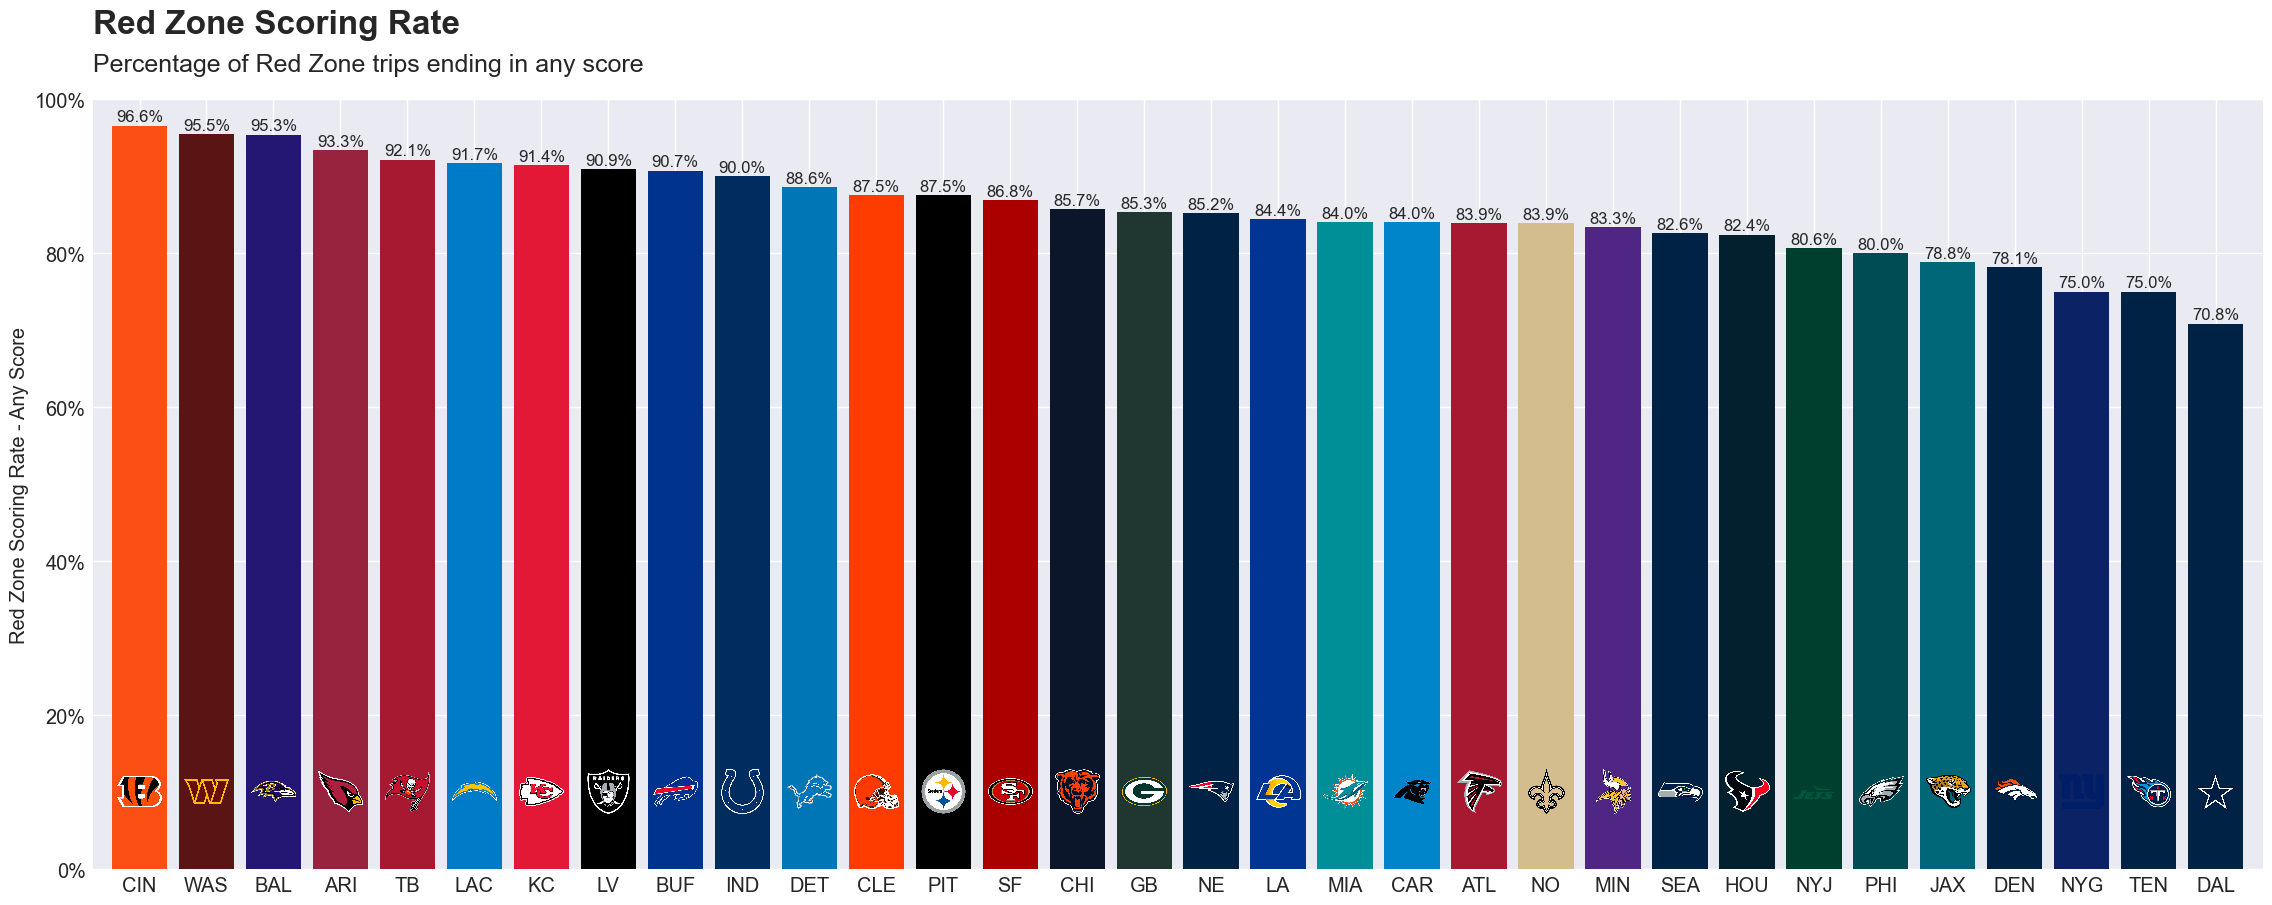

In [26]:
# red zone scoring rate - any score
fig, ax = bar_chart_perc('total_rz_eff')

# save plot
plt.savefig('visualizations/total_rz_eff.png')

# display plot
plt.show()

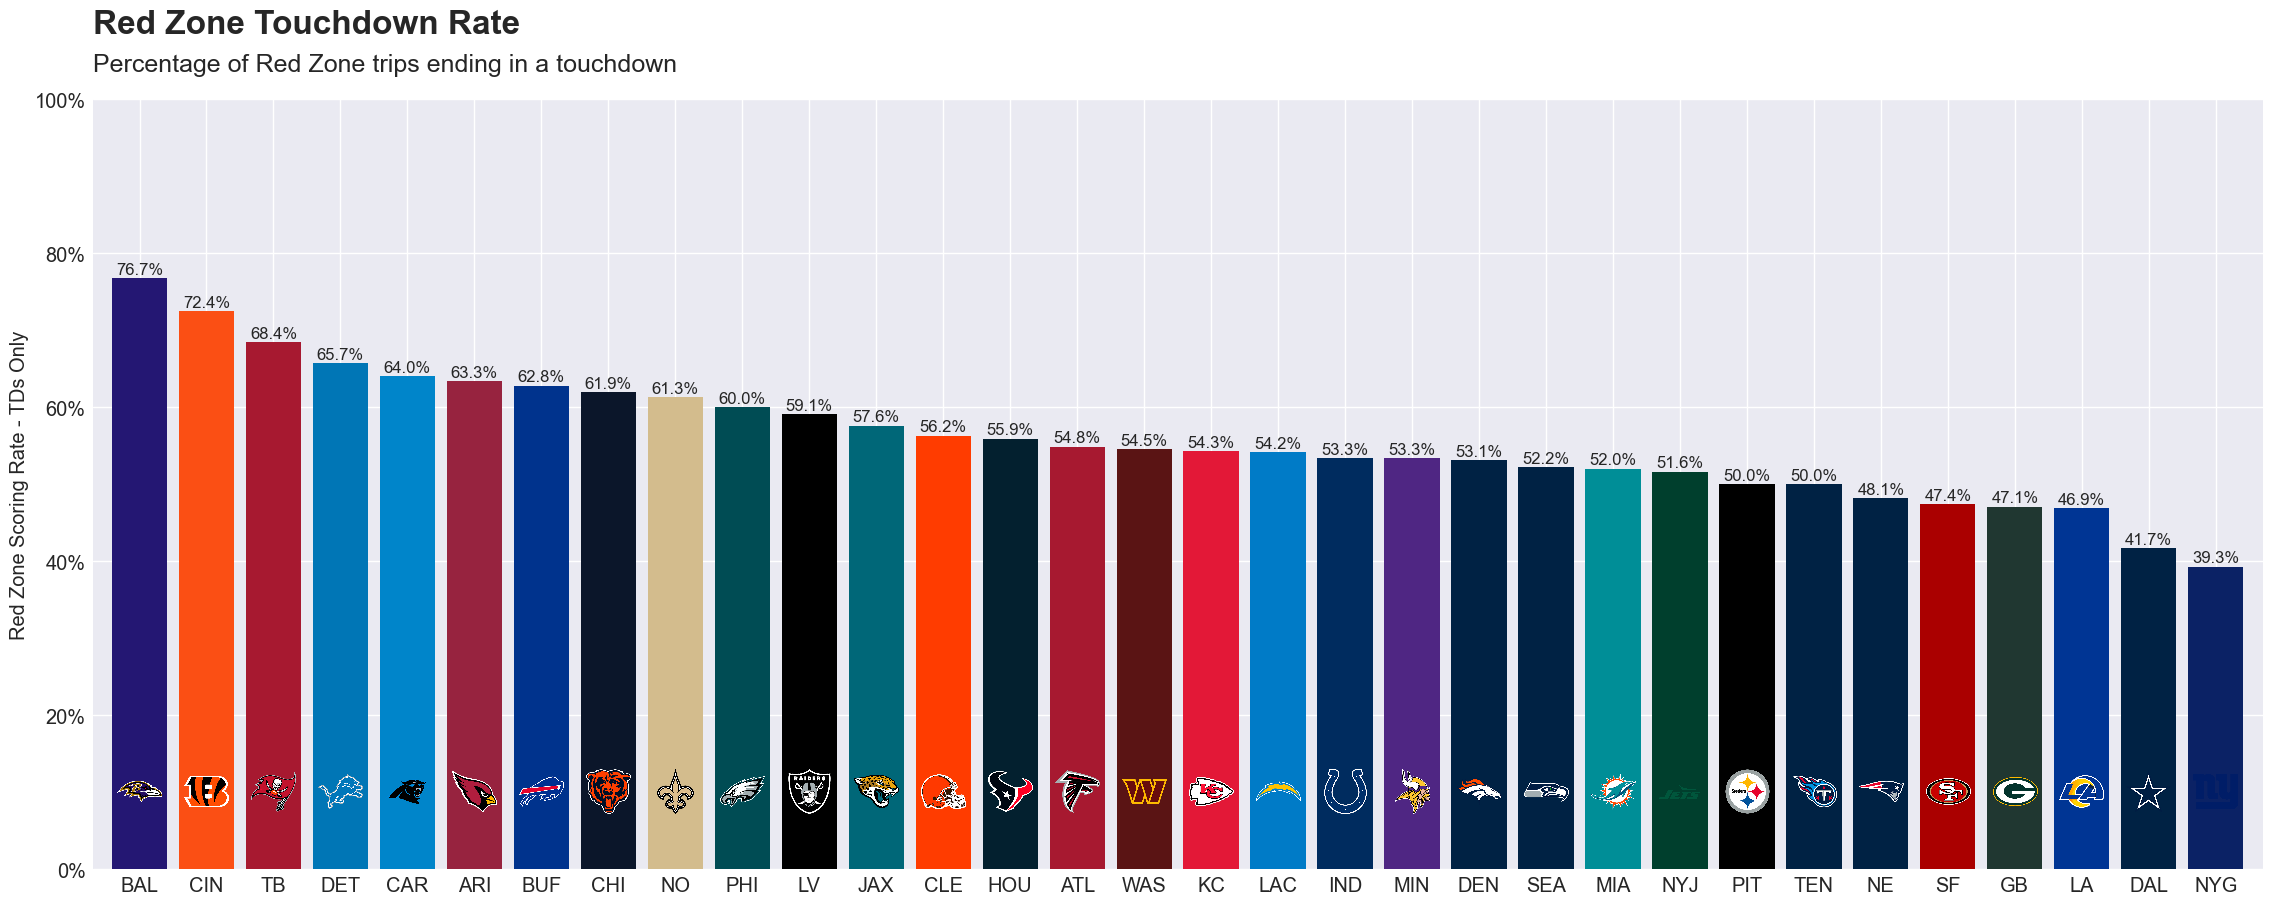

In [27]:
# TD rate
fig, ax = bar_chart_perc('td_rz_eff')
plt.savefig('visualizations/td_rz_eff.png')
plt.show()

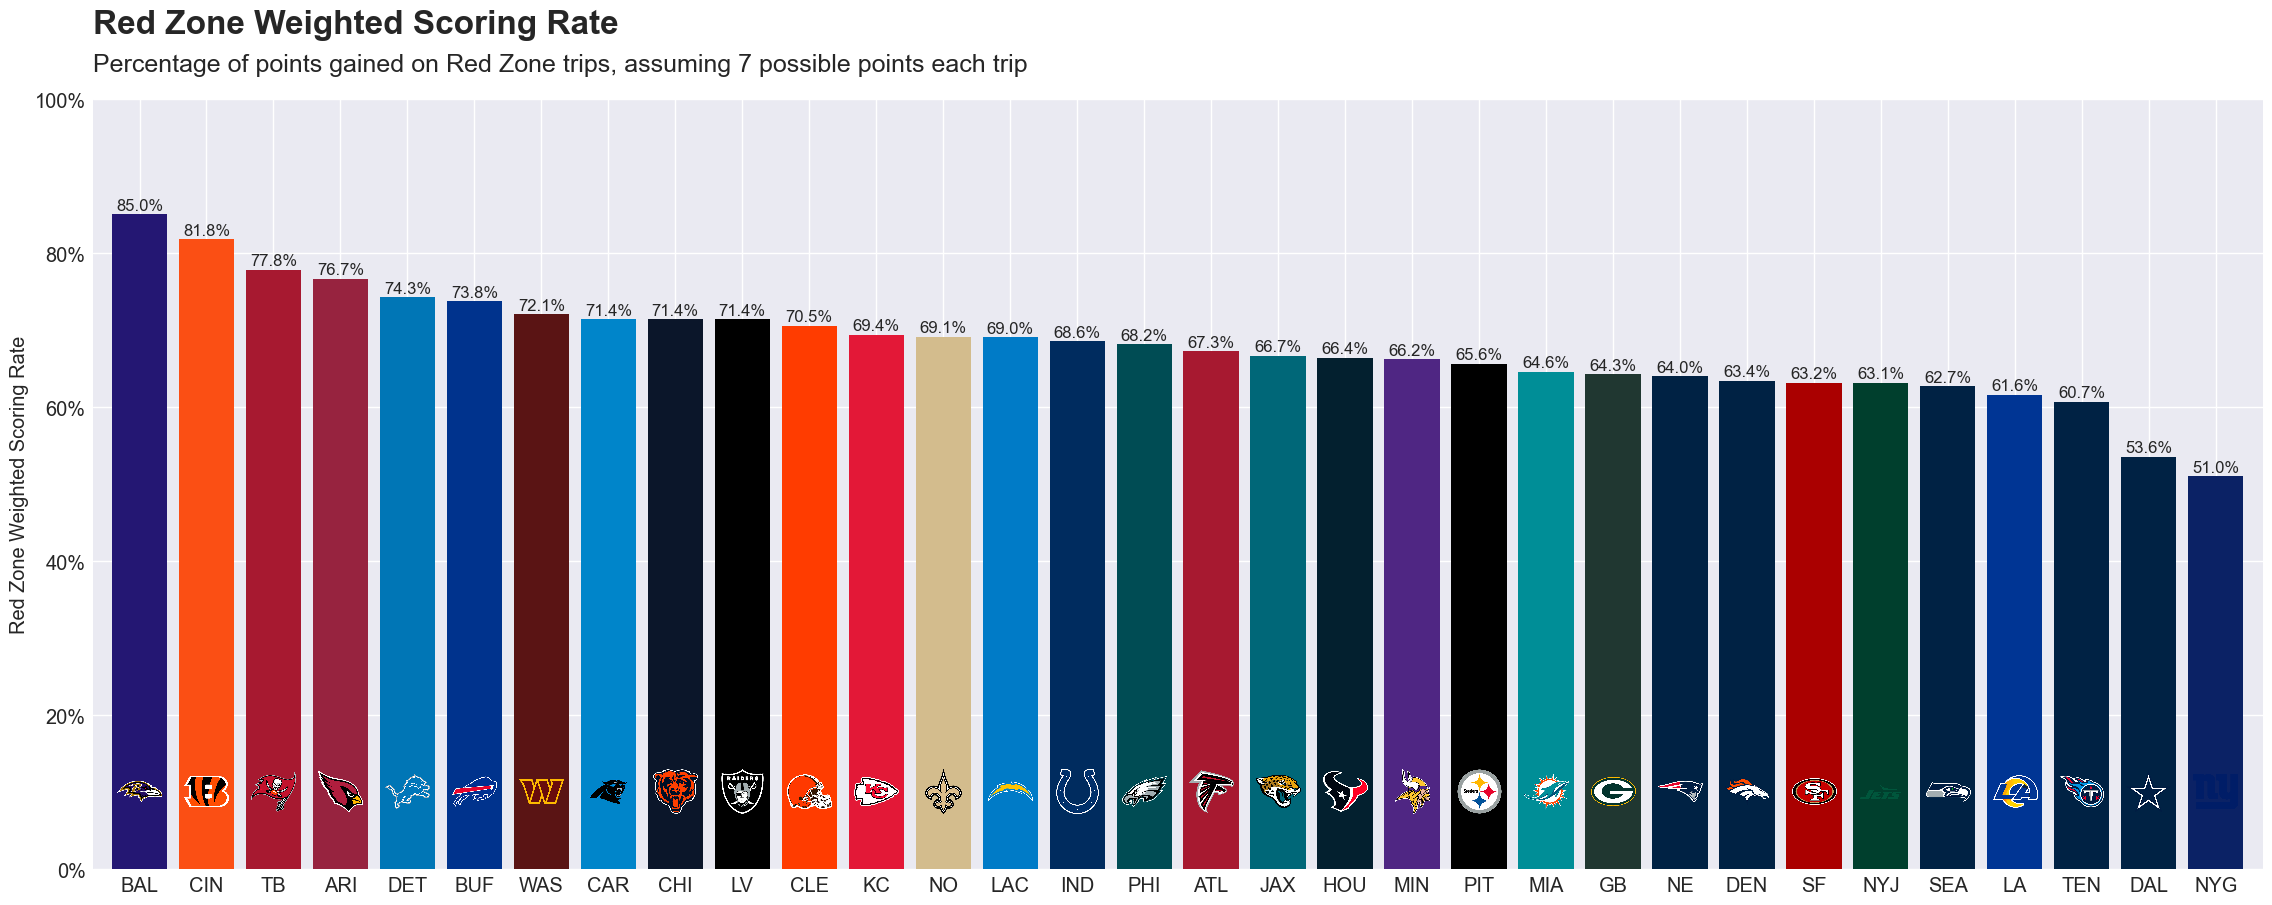

In [28]:
# weighted rate
fig, ax = bar_chart_perc('weighted_rz_eff')
plt.savefig('visualizations/weighted_rz_eff.png')
plt.show()

#### EPA and WPA Metrics

In [29]:
# function to create bar charts for the EPA and WPA metrics
def bar_chart_adv(metric):
    # args: metric - string, column name of metric to be plotted

    plt.style.use('seaborn-v0_8')

    bc1 = viz_data.sort_values(metric, ascending=False)
    team = bc1['team_abbr']
    value = bc1[metric]
    logo_path = bc1['team_logo_file']
    team_color = bc1['team_color']

    fig, ax = plt.subplots(figsize=(28,10))
    bar_container = ax.bar(team, value, width=0.825, color=team_color)

    # pad axes
    ax.xaxis.set_tick_params(pad=5)
    ax.yaxis.set_tick_params(pad=5)

    # Add annotation to bars
    # numeric precision varies by metric
    if metric in ('epa', 'wpa'):
        num_format = '{:.1f}'
    elif metric == 'rz_epa_pp':
        num_format = '{:.2f}'
    elif metric == 'rz_wpa_pp':
        num_format = '{:.3f}'
    
    ax.bar_label(bar_container, fmt=num_format, label_type='edge', padding=1, fontsize='x-large')

    # image placement, axis limits, and titles will vary by metric
    metric_dict = {'epa': {'ylabel': 'Total EPA',
                            'subtitle': 'Total Expected Points Added on plays in the Red Zone, excluding PATs and Two-Point Attempts',
                            'title': 'Total Expected Points Added (EPA) in Red Zone',
                            'image_offsets': {'pos': 5.5, 'neg': -5.75},
                            'y_lim_offsets': {'pos': 8, 'neg': -9}},
            'rz_epa_pp': {'ylabel': 'EPA Per Play',
                            'subtitle': 'Average Expected Points Added per Red Zone play',
                            'title': 'EPA Per Play in Red Zone',
                            'image_offsets': {'pos': 0.061, 'neg': -0.062},
                            'y_lim_offsets': {'pos': 0.1, 'neg': -0.11}},
            'wpa': {'ylabel': 'Total WPA',
                            'subtitle': 'Win Probability Added on plays in the Red Zone, excluding PATs and Two-Point Attemtps',
                            'title': 'Total Win Probability Added (WPA) in Red Zone',
                            'image_offsets': {'pos': 0.2, 'neg': -0.21},
                            'y_lim_offsets': {'pos': 0.4, 'neg': -0.4}},
            'rz_wpa_pp': {'ylabel': 'WPA Per Play',
                            'subtitle': 'Average Win Probability Added per Red Zone play',
                            'title': 'WPA Per Play in Red Zone',
                            'image_offsets': {'pos': 0.002, 'neg': -0.0021},
                            'y_lim_offsets': {'pos': 0.003, 'neg': -0.003}}}

    # Add image annotation to bars
    for x0, y0, path in zip(team, value, logo_path):
        # zoom of logo images (Jets logo is way too big)
        if x0 == 'NYJ':
            zoom = 0.008
        else:
            zoom = 0.07

        # offset logos above bar if positive, below bar if negative
        if y0 >= 0:
            y_offset = metric_dict[metric]['image_offsets']['pos']
        else:
            y_offset = metric_dict[metric]['image_offsets']['neg']
        
        ab = AnnotationBbox(getImage(path, zoom), (x0, y0+y_offset), frameon=False)
        ax.add_artist(ab)

    # set axis ticks and labels
    ax.set_xticks(np.arange(len(team)), labels=team, ha='center', fontsize='x-large')
    ax.yaxis.set_tick_params(labelsize='x-large')

    # set axis limits to adjust margins
    ax.set_xlim(-0.7, 31.7)
    ax.set_ylim(value.min()+metric_dict[metric]['y_lim_offsets']['neg'],
                value.max()+metric_dict[metric]['y_lim_offsets']['pos'])

    #set titles
    ax.set_ylabel(metric_dict[metric]['ylabel'], fontsize='x-large')
    ax.set_title(metric_dict[metric]['subtitle'], fontsize=18, pad=20, loc='left') #sets sub-title
    fig.suptitle(metric_dict[metric]['title'], fontsize=24, fontweight='bold', x=0.125, y=0.97, ha='left') #sets title

    return fig, ax

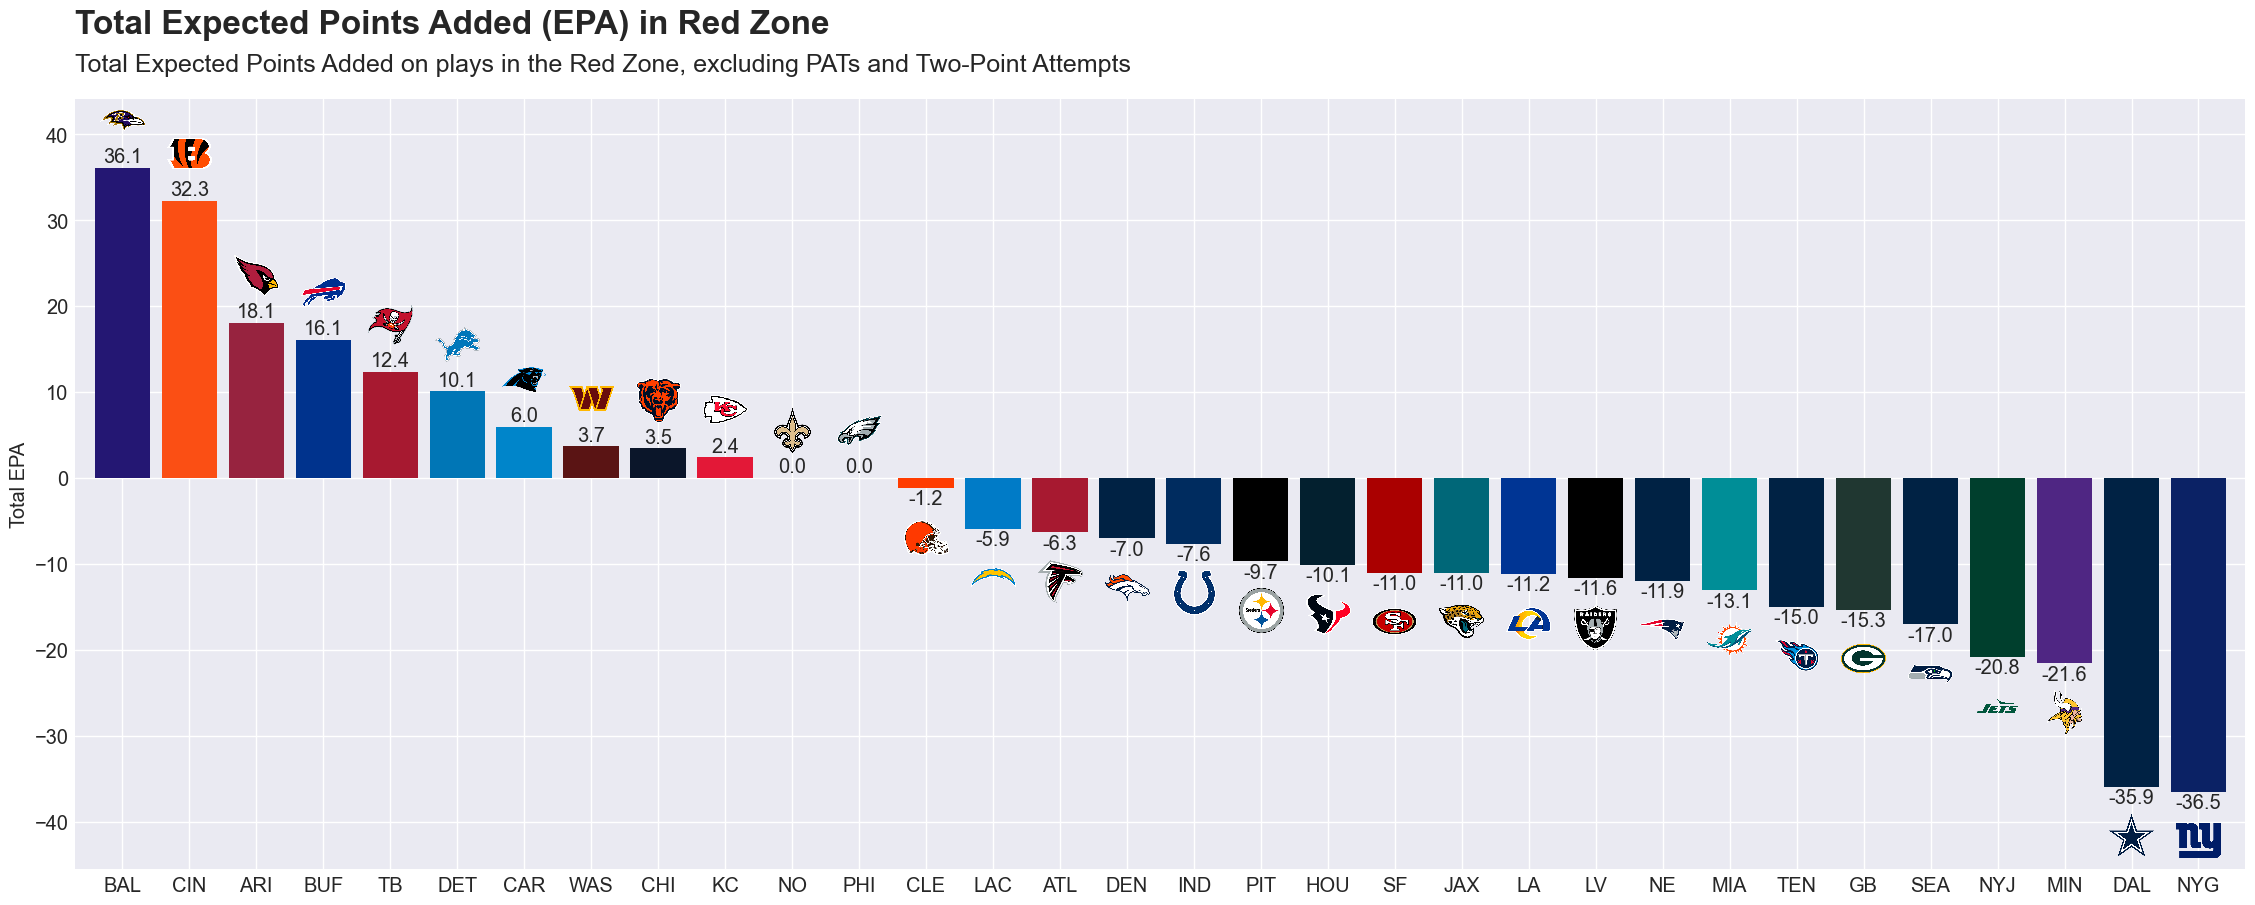

In [30]:
# Total EPA
fig, ax = bar_chart_adv('epa')

# save plot
plt.savefig('visualizations/epa_total.png')

# display plot
plt.show()

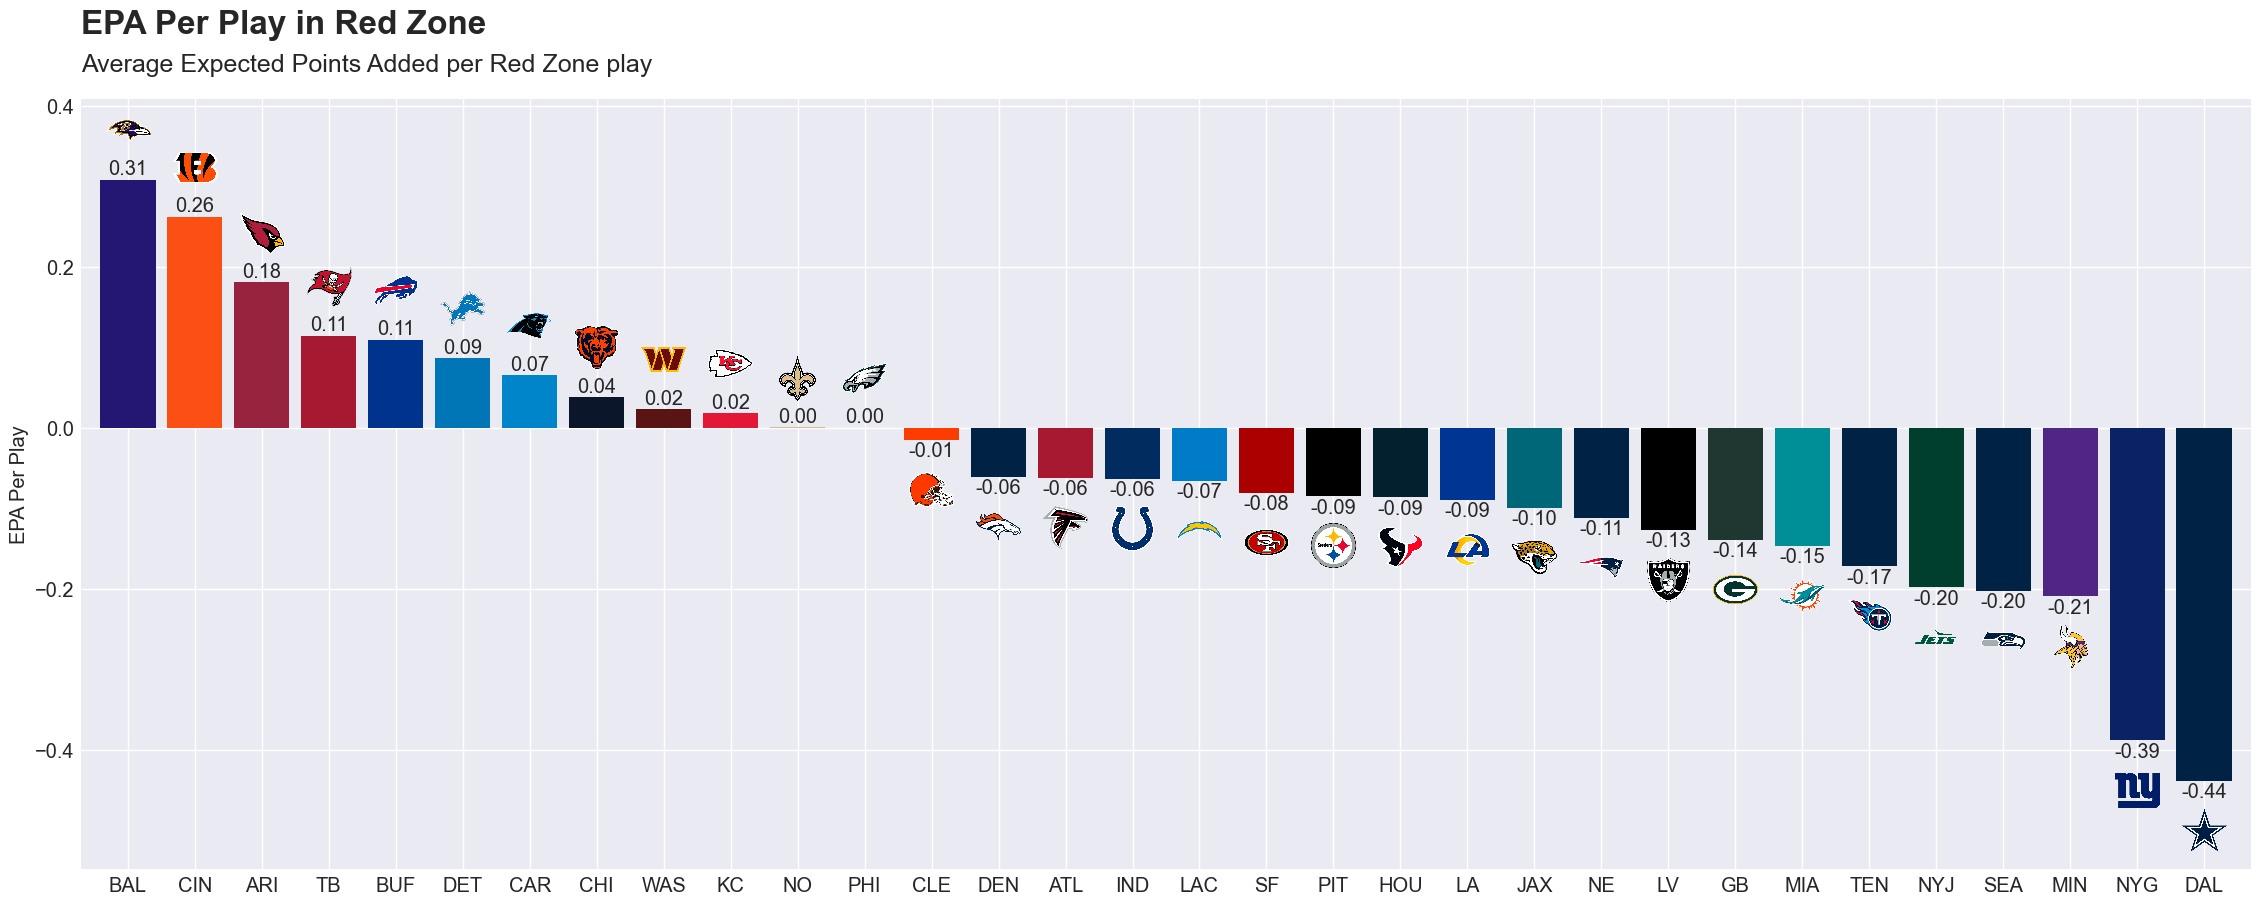

In [31]:
# EPA per play
fig, ax = bar_chart_adv('rz_epa_pp')
plt.savefig('visualizations/epa_pp.png')
plt.show()

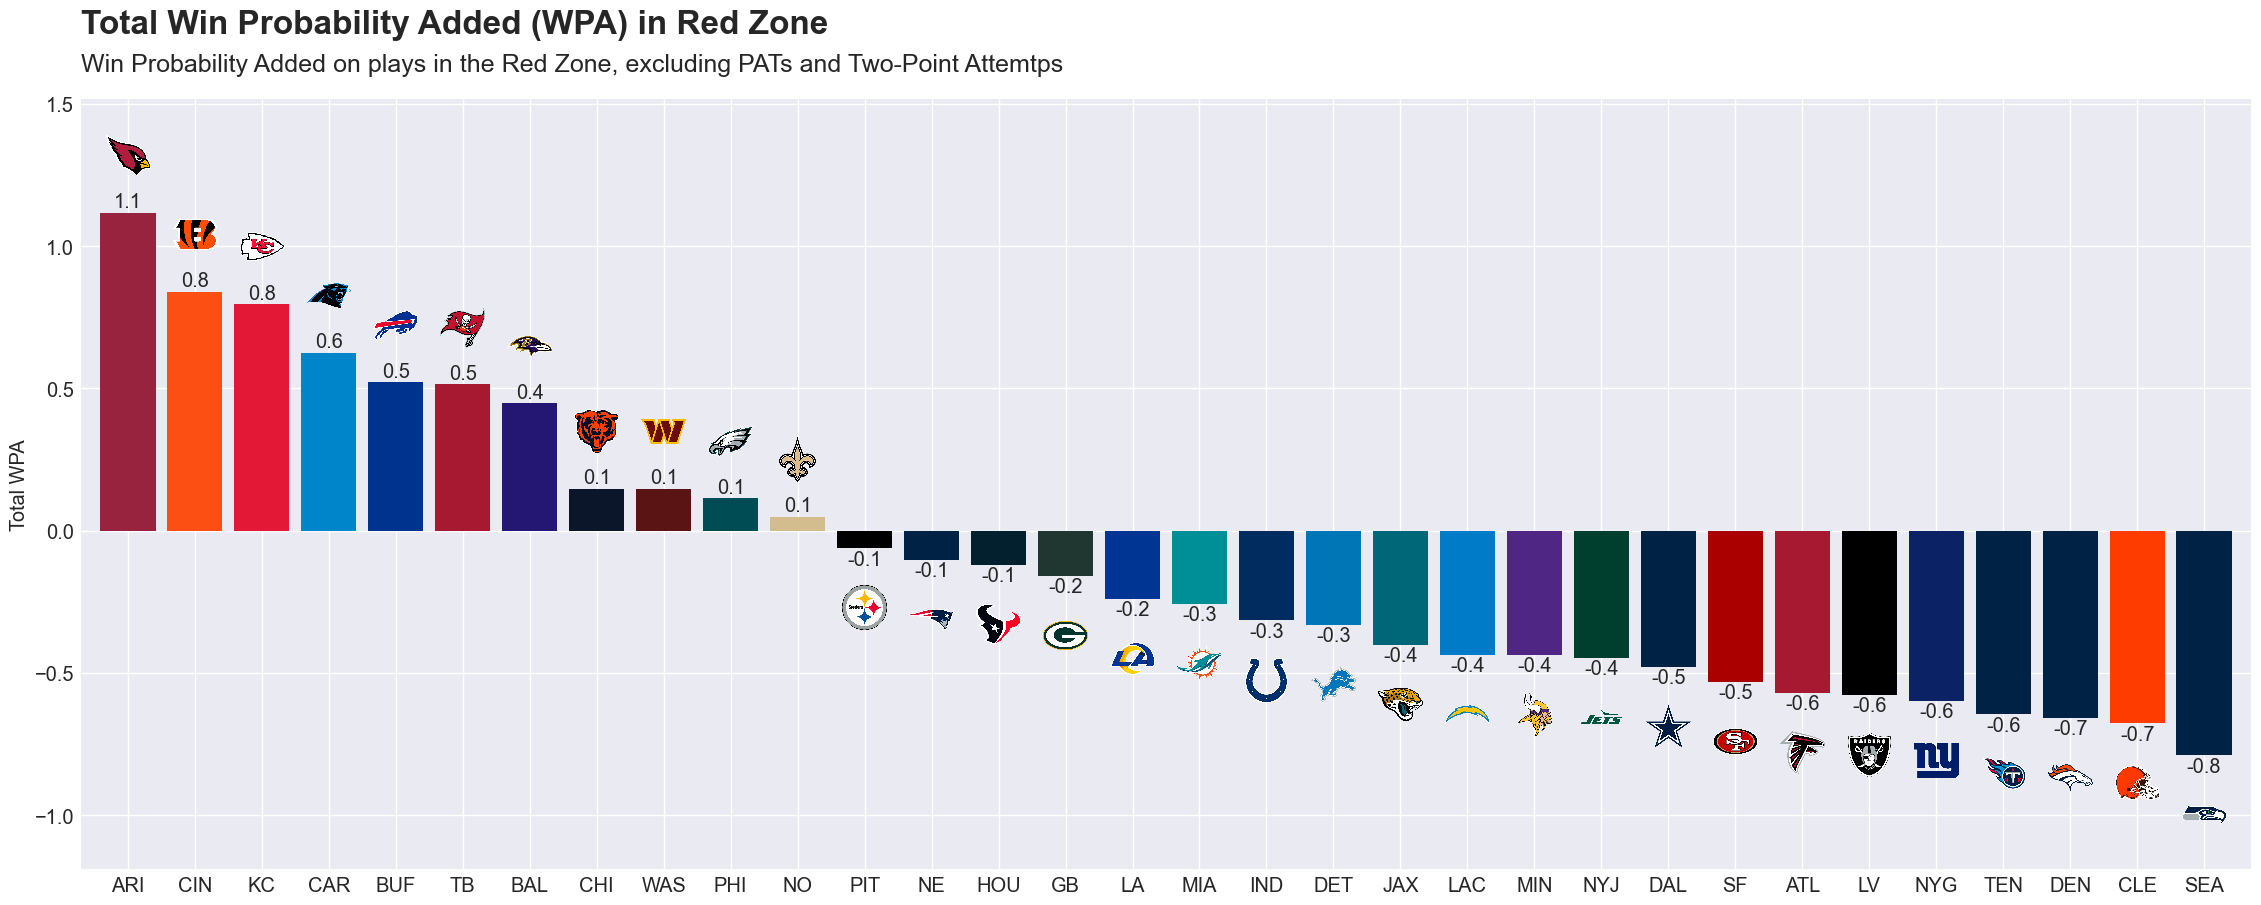

In [32]:
# Total WPA
fig, ax = bar_chart_adv('wpa')
plt.savefig('visualizations/wpa_total.png')
plt.show()

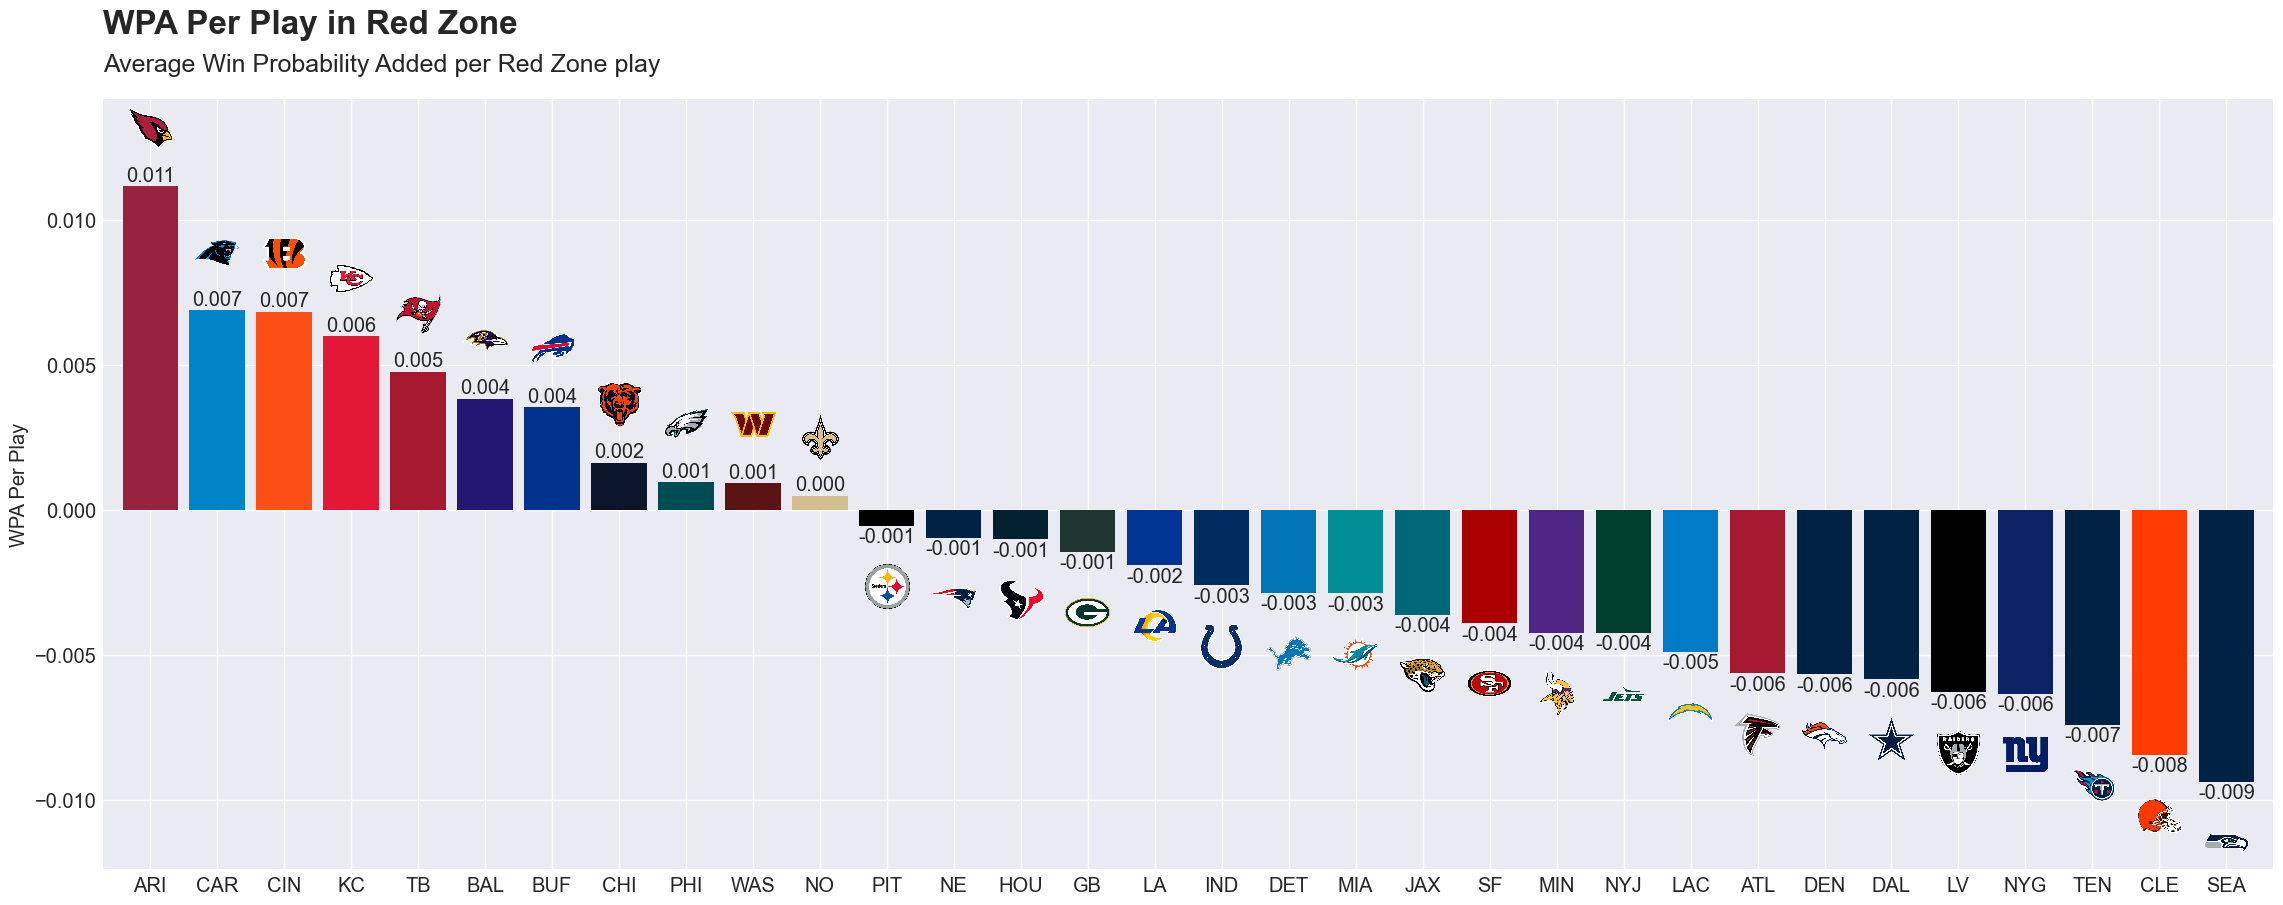

In [33]:
# WPA per play
fig, ax = bar_chart_adv('rz_wpa_pp')
plt.savefig('visualizations/wpa_pp.png')
plt.show()

## Conclusions
I would argue that the weighted scoring rate is a more holistic red zone metric than either the overall scoring rate or the touchdown rate. The weighted metric improves on the overall rate by rewarding teams for scoring touchdowns over field goals, but it also improves on the touchdown rate by rewarding teams for not turning the ball over and converting field goals.

The biggest beneficiaries of a switch from overall rate to weighted rate would be teams with a below-average scoring rate and above-average touchdown rate. These teams may be more aggressive in attempting 4th-down conversions instead of field goals. They may also be more prone to turnovers. These teams are touchdown or bust.
- CAR: 19th Overall -> 8th Weighted (+11)
- PHI: 27th Overall -> 16th Weighted (+11)
- JAX: 28th Overall -> 18th Weighted (+10)
- NO: 21st Overall -> 13th Weighted (+8)
- CHI: 15th Overall -> 8th Weighted (+7)

The biggest beneficiaries of a switch from touchdown rate to weighted rate would be teams with an above-average scoring rate and below-average touchdown rate. These teams may be more conservative about attempting fields rather than 4th-down conversions. They may also be less prone to turnovers. These teams are determined to come away with points.
- WAS: 16th TD Rate -> 7th Weighted (+9)
- GB: 29th TD Rate -> 23rd Weighted (+6)
- KC: 17th TD Rate -> 12th Weighted (+5)
- IND (19->15), LAC (18->14), PIT (25->21) tied at +4

Just 2 teams would benefit from a change to weighted scoring rate regardless of the status quo metric. These teams have very similar rankings between overall scoring rate and touchdown rate. They may also benefit from success on PAT and 2-point conversion attempts, which are a factor in the weighted average.
- BUF: 9th Overall, 7th TD Rate -> 6th Weighted
- CLE: 12th Overall, 13th TD Rate -> 11th Weighted
Several other teams have a weighted rate tied with their scoring rate or touchdown rate.

Note: the statistics above are accurate as of Week 10 of 2024.

The advanced metrics of Expected Points Added (EPA), Win Probability Added (WPA), and their respective per-play averages are still considered more comprehensive and precise metrics. However, scoring rate and touchdown rate are still preferred by broadcasts and major media outlets because of its familiarity to fans. If weighted scoring rate could be introduced as an alternative, it could be a happy middle ground between the basic rates and advanced metrics—more precise than the rates and more digestible than EPA or WPA.